In [1]:
!pip install pretty_midi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=3ee63402ab90ba370f327b717725cc13f1cc3222bd237478c7fcde081a3547e7
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Reshape, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pretty_midi
from sklearn.model_selection import train_test_split

In [ ]:
# Define the generator with additional parameters for tempo, chord progression, and instrument
def build_generator(latent_dim, num_notes, num_instruments):
    # Input layers for noise, tempo, chord progression, and instrument
    noise = Input(shape=(latent_dim,))
    tempo = Input(shape=(1,))
    chord_progression = Input(shape=(num_chords,))
    instrument = Input(shape=(num_instruments,))

    # Concatenate the inputs
    x = concatenate([noise, tempo, chord_progression, instrument])

    # Generator network architecture
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    output_notes = Dense(num_notes, activation='sigmoid')(x)
    return Model([noise, tempo, chord_progression, instrument], output_notes)

# Define the discriminator (unchanged)
def build_discriminator(num_notes):
    music = Input(shape=(num_notes,))
    x = Reshape((num_notes, 1))(music)
    x = LSTM(512)(x)
    validity = Dense(1, activation='sigmoid')(x)
    return Model(music, validity)

In [ ]:
# Define the dimensions and parameters
latent_dim = 100
num_notes = 128  # Number of notes in a music piece
num_chords = 4   # Number of chords in the chord progression
num_instruments = 128  # Total number of instruments (adjust as needed)
epochs = 500      # Reduced number of epochs
batch_size = 32   # Reduced batch size for faster training # NOTE (Actually, you would increase it for faster training)

In [ ]:
def parser(self, folderName):

        for file in glob.glob(f"{folderName}/*.mid"):
            midi = converter.parse(file)
            print("Parsing %s" % file)

            notes = []
            for element in midi.flat.elements:
                if isinstance(element, note.Rest) and element.offset != 0:
                    notes.append('R')
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                if isinstance(element, chord.Chord):
                    notes.append('.'.join(str(pitch) for pitch in element.pitches))

            self.file_notes.append(notes)
        note_set = sorted(set(note for notes in self.file_notes for note in notes))
        self.dic_n = len(note_set)
        # A dictionary to map notes, chords and rest to integers
        self.transfer_dic = dict((note, number) for number, note in enumerate(note_set))


vanilla gans for piano
train test vali included

In [5]:






# Placeholder for training data (replace this with your actual training data)
X = np.random.rand(1000, num_notes)
X_train, X_test_validate = train_test_split(X, test_size=0.2, random_state=42)  # NOTE I am not sure why there is a need for a test/train set?
X_test, X_validate = train_test_split(X_test_validate, test_size=0.5, random_state=42)

# Build the generator and discriminator
generator = build_generator(latent_dim, num_notes, num_instruments)
discriminator = build_discriminator(num_notes)  # NOTE: Is output_notes the same value as num_notes?

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# The generator takes noise, tempo, chord progression, and instrument as input and generates music
noise = Input(shape=(latent_dim,))
tempo = Input(shape=(1,))
chord_progression = Input(shape=(num_chords,))
instrument = Input(shape=(num_instruments,))
generated_music = generator([noise, tempo, chord_progression, instrument])

# For the combined model, only train the generator
discriminator.trainable = False  # NOTE: Why would you only train the generator??
# NOTE: When the generator is being trained, the discriminator is freezed and vice-versa.
# NOTE: please go through this colab notebook "https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb"

# The discriminator takes generated music as input and determines validity
validity = discriminator(generated_music)

# The combined model (stacked generator and discriminator)
combined = Model([noise, tempo, chord_progression, instrument], validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training loop
for epoch in range(epochs):
    # Select a random batch of music
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_music = X_train[idx]

    # Generate a batch of new music
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Adjust the instrument to violin (41 is the program number for Violin)
    instrument_data = np.ones((batch_size, num_notes)) * 41

    # Adjust the chord progression to CFCG
    chord_progression_data = np.array([[0, 5, 7, 10]] * batch_size)

    # Adjust the tempo to 120 BPM
    tempo_data = np.ones((batch_size, 1)) * 120

    generated_music = generator.predict([noise, tempo_data, chord_progression_data, instrument_data])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_music, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_music, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # NOTE: Put this value in an array.

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch([noise, tempo_data, chord_progression_data, instrument_data], np.ones((batch_size, 1)))  # NOTE: put this value in a different array

    # Print progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

# Testing the model
# Select a random batch of music from the test set
idx = np.random.randint(0, X_test.shape[0], batch_size)
real_music_test = X_test[idx]

# Generate a batch of new music
noise_test = np.random.normal(0, 1, (batch_size, latent_dim))
instrument_data_test = np.ones((batch_size, num_notes)) * 41  # Adjust the instrument to violin
chord_progression_data_test = np.array([[0, 5, 7, 10]] * batch_size)  # Adjust the chord progression to CFCG
tempo_data_test = np.ones((batch_size, 1)) * 120  # Adjust the tempo to 120 BPM

generated_music_test = generator.predict([noise_test, tempo_data_test, chord_progression_data_test, instrument_data_test])

# NOTE: I am not sure if this is the evaluation metric for GANs. A better way would be to plot a simultaneous graph of loss values from
# generator and discriminator

# Evaluate the generated music with the discriminator
accuracy = discriminator.evaluate(generated_music_test, np.zeros((batch_size, 1)))[1]
print("Accuracy on generated music samples:", accuracy)

# Generate some music samples (adjust num_samples as needed)
def generate_music(generator, num_samples=1):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    tempo_data = np.ones((num_samples, 1)) * 120  # Tempo set to 120 BPM for all samples
    chord_progression_data = np.array([[0, 5, 7, 10]] * num_samples)  # Chord progression set to CFCG for all samples
    instrument_data = np.ones((num_samples, num_instruments)) * 41  # Instrument set to Violin (41) for all samples
    generated_music = generator.predict([noise, tempo_data, chord_progression_data, instrument_data])
    return generated_music

# Example usage
generated_samples = generate_music(generator, num_samples=5)

# Save the generated samples as MIDI files
for i, sample in enumerate(generated_samples):
    midi_data = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    for time, note_prob in enumerate(sample):
        if note_prob > 0.5:  # Play the note if the probability is above a threshold
            pitch = np.random.randint(0, 128)  # Random pitch between 0 and 127
            velocity = np.random.randint(0, 128)  # Random velocity between 0 and 127
            note_start = time * 0.5  # Each time step is 0.5 seconds
            note_end = note_start + 0.5
            midi_note = pretty_midi.Note(
                velocity=velocity, pitch=pitch, start=note_start, end=note_end)
            piano.notes.append(midi_note)
    midi_data.instruments.append(piano)
    midi_data.write(f'generated_music_{i}.mid')


1/1 [==============================] - 0s 61ms/step
0 [D loss: 0.707469, acc.: 0.00%] [G loss: 0.696442]
1/1 [==============================] - 0s 18ms/step
1 [D loss: 0.699488, acc.: 4.69%] [G loss: 0.695871]
1/1 [==============================] - 0s 18ms/step
2 [D loss: 0.697699, acc.: 0.00%] [G loss: 0.700696]
1/1 [==============================] - 0s 18ms/step
3 [D loss: 0.696594, acc.: 50.00%] [G loss: 0.705557]
1/1 [==============================] - 0s 21ms/step
4 [D loss: 0.696272, acc.: 50.00%] [G loss: 0.708591]
1/1 [==============================] - 0s 20ms/step
5 [D loss: 0.695305, acc.: 50.00%] [G loss: 0.711140]
1/1 [==============================] - 0s 22ms/step
6 [D loss: 0.695987, acc.: 50.00%] [G loss: 0.710768]
1/1 [==============================] - 0s 29ms/step
7 [D loss: 0.697365, acc.: 50.00%] [G loss: 0.706570]
1/1 [==============================] - 0s 22ms/step
8 [D loss: 0.699178, acc.: 50.00%] [G loss: 0.699787]
1/1 [==============================] - 0s 21ms/st

0 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
1 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
2 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
3 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
4 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
5 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
6 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
7 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
8 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
9 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
10 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
11 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
12 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
13 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
14 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
15 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
16 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
17 [D loss: 0.082579, acc.: 100.00%] [G loss: 6.163241]
18

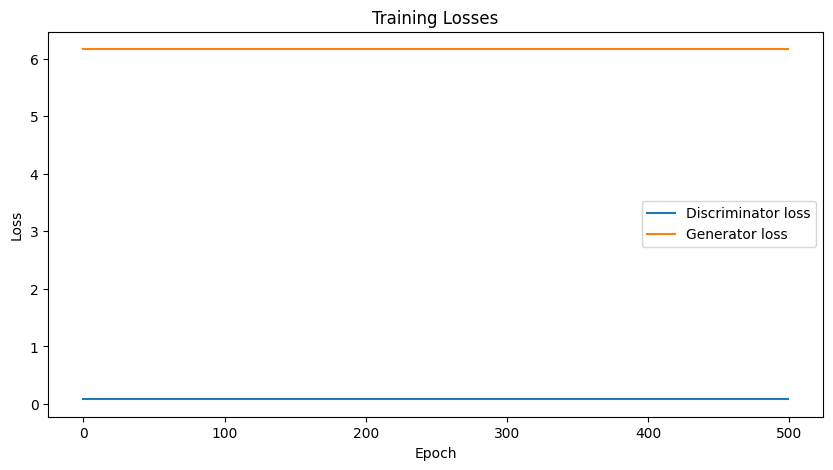

In [6]:
import matplotlib.pyplot as plt

# NOTE: uhh, I am not sure what you are trying to do with this snippet but this is not how you would plot losses. Instead, losses would be recorded
# while the model is training not after it's finished.

# NOTE: I have mentioned in the training code above about the creation of two arrays. Now take the values from those arrays and plot it. That would be your graph.
# Training loop
d_losses, g_losses = [], []
for epoch in range(epochs):
    # ...
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    # Print progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

# Plot the discriminator and generator losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# NOTE: I'll be honest here. This graph is not looking good at all. 


above was vanilla gan for piano with test train

below is same but with violin

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Reshape, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pretty_midi
from sklearn.model_selection import train_test_split

# Define the generator with additional parameters for tempo, chord progression, and instrument
def build_generator(latent_dim, num_notes, num_instruments):
    # Input layers for noise, tempo, chord progression, and instrument
    noise = Input(shape=(latent_dim,))
    tempo = Input(shape=(1,))
    chord_progression = Input(shape=(num_chords,))
    instrument = Input(shape=(num_instruments,))

    # Concatenate the inputs
    x = concatenate([noise, tempo, chord_progression, instrument])

    # Generator network architecture
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    output_notes = Dense(num_notes, activation='sigmoid')(x)
    return Model([noise, tempo, chord_progression, instrument], output_notes)

# Define the discriminator (unchanged)
def build_discriminator(num_notes):
    music = Input(shape=(num_notes,))
    x = Reshape((num_notes, 1))(music)
    x = LSTM(512)(x)
    validity = Dense(1, activation='sigmoid')(x)
    return Model(music, validity)

# Define the dimensions and parameters
latent_dim = 100
num_notes = 128  # Number of notes in a music piece
num_chords = 4   # Number of chords in the chord progression
num_instruments = 128  # Total number of instruments (adjust as needed)
epochs = 500      # Reduced number of epochs
batch_size = 32   # Reduced batch size for faster training

# Placeholder for training data (replace this with your actual training data)
X = np.random.rand(1000, num_notes)
X_train, X_test_validate = train_test_split(X, test_size=0.2, random_state=42)
X_test, X_validate = train_test_split(X_test_validate, test_size=0.5, random_state=42)

# Build the generator and discriminator
generator = build_generator(latent_dim, num_notes, num_instruments)
discriminator = build_discriminator(num_notes)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# The generator takes noise, tempo, chord progression, and instrument as input and generates music
noise = Input(shape=(latent_dim,))
tempo = Input(shape=(1,))
chord_progression = Input(shape=(num_chords,))
instrument = Input(shape=(num_instruments,))
generated_music = generator([noise, tempo, chord_progression, instrument])

# For the combined model, only train the generator
discriminator.trainable = False

# The discriminator takes generated music as input and determines validity
validity = discriminator(generated_music)

# The combined model (stacked generator and discriminator)
combined = Model([noise, tempo, chord_progression, instrument], validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training loop
for epoch in range(epochs):
    # Select a random batch of music
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_music = X_train[idx]

    # Generate a batch of new music
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Adjust the instrument to violin (41 is the program number for Violin)
    instrument_data = np.ones((batch_size, num_notes)) * 41

    # Adjust the chord progression to CFCG
    chord_progression_data = np.array([[0, 5, 7, 10]] * batch_size)

    # Adjust the tempo to 120 BPM
    tempo_data = np.ones((batch_size, 1)) * 120

    generated_music = generator.predict([noise, tempo_data, chord_progression_data, instrument_data])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_music, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_music, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch([noise, tempo_data, chord_progression_data, instrument_data], np.ones((batch_size, 1)))

    # Print progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

# Testing the model
# Select a random batch of music from the test set
idx = np.random.randint(0, X_test.shape[0], batch_size)
real_music_test = X_test[idx]

# Generate a batch of new music
noise_test = np.random.normal(0, 1, (batch_size, latent_dim))
instrument_data_test = np.ones((batch_size, num_notes)) * 41  # Adjust the instrument to violin
chord_progression_data_test = np.array([[0, 5, 7, 10]] * batch_size)  # Adjust the chord progression to CFCG
tempo_data_test = np.ones((batch_size, 1)) * 120  # Adjust the tempo to 120 BPM

generated_music_test = generator.predict([noise_test, tempo_data_test, chord_progression_data_test, instrument_data_test])

# Evaluate the generated music with the discriminator
accuracy = discriminator.evaluate(generated_music_test, np.zeros((batch_size, 1)))[1]
print("Accuracy on generated music samples:", accuracy)

# Generate some music samples (adjust num_samples as needed)
def generate_music(generator, num_samples=1):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    tempo_data = np.ones((num_samples, 1)) * 120  # Tempo set to 120 BPM for all samples
    chord_progression_data = np.array([[0, 5, 7, 10]] * num_samples)  # Chord progression set to CFCG for all samples
    instrument_data = np.ones((num_samples, num_instruments)) * 41  # Instrument set to Violin (41) for all samples
    generated_music = generator.predict([noise, tempo_data, chord_progression_data, instrument_data])
    return generated_music

# Example usage
generated_samples = generate_music(generator, num_samples=5)

# Save the generated samples as MIDI files
for i, sample in enumerate(generated_samples):
    midi_data = pretty_midi.PrettyMIDI()
    violin_program = pretty_midi.instrument_name_to_program('Violin')
    violin = pretty_midi.Instrument(program=violin_program)
    for time, note_prob in enumerate(sample):
        if note_prob > 0.5:  # Play the note if the probability is above a threshold
            pitch = np.random.randint(0, 128)  # Random pitch between 0 and 127
            velocity = np.random.randint(0, 128)  # Random velocity between 0 and 127
            note_start = time * 0.5  # Each time step is 0.5 seconds
            note_end = note_start + 0.5
            midi_note = pretty_midi.Note(
                velocity=velocity, pitch=pitch, start=note_start, end=note_end)
            violin.notes.append(midi_note)
    midi_data.instruments.append(violin)
    midi_data.write(f'generated_music_{i}.mid')


1/1 [==============================] - 0s 140ms/step
0 [D loss: 0.706652, acc.: 50.00%] [G loss: 0.671986]
1/1 [==============================] - 0s 20ms/step
1 [D loss: 0.702380, acc.: 50.00%] [G loss: 0.670520]
1/1 [==============================] - 0s 20ms/step
2 [D loss: 0.701248, acc.: 50.00%] [G loss: 0.677900]
1/1 [==============================] - 0s 21ms/step
3 [D loss: 0.698637, acc.: 50.00%] [G loss: 0.691136]
1/1 [==============================] - 0s 20ms/step
4 [D loss: 0.695293, acc.: 50.00%] [G loss: 0.706068]
1/1 [==============================] - 0s 19ms/step
5 [D loss: 0.692597, acc.: 50.00%] [G loss: 0.720006]
1/1 [==============================] - 0s 20ms/step
6 [D loss: 0.690222, acc.: 50.00%] [G loss: 0.732183]
1/1 [==============================] - 0s 19ms/step
7 [D loss: 0.689628, acc.: 50.00%] [G loss: 0.740627]
1/1 [==============================] - 0s 20ms/step
8 [D loss: 0.688077, acc.: 50.00%] [G loss: 0.749577]
1/1 [==============================] - 0s 20m

CGAN Train test with piano

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Reshape, LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pretty_midi
from sklearn.model_selection import train_test_split

# Define the generator
def build_generator(latent_dim, num_notes, num_genres):
    notes_input = Input(shape=(latent_dim,))
    genre_input = Input(shape=(num_genres,))
    concatenated = Concatenate()([notes_input, genre_input])
    x = Dense(256, activation='relu')(concatenated)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    output_notes = Dense(num_notes, activation='softmax')(x)
    return Model([notes_input, genre_input], output_notes)

# Define the discriminator
def build_discriminator(num_notes, num_genres):
    music_input = Input(shape=(num_notes,))
    genre_input = Input(shape=(num_genres,))
    x = Reshape((num_notes, 1))(music_input)
    x = LSTM(512)(x)
    x = Concatenate()([x, genre_input])
    validity = Dense(1, activation='sigmoid')(x)
    return Model([music_input, genre_input], validity)

# Define the dimensions and parameters
latent_dim = 100
num_notes = 128  # Number of notes in a music piece
num_genres = 5  # Number of genres
epochs = 500
batch_size = 32
output_length = 15  # Duration of output MIDI in seconds

# Placeholder for training data (replace this with your actual training data)
X = np.random.rand(1000, num_notes)
y = np.random.randint(0, 2, (1000, num_genres))

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# Build and compile the discriminator
discriminator = build_discriminator(num_notes, num_genres)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim, num_notes, num_genres)

# The generator takes random noise and genre as input and generates music
noise_input = Input(shape=(latent_dim,))
genre_input = Input(shape=(num_genres,))
generated_music = generator([noise_input, genre_input])

# For the combined model, only train the generator
discriminator.trainable = False

# The discriminator takes generated music and genre as input and determines validity
validity = discriminator([generated_music, genre_input])

# The combined model (stacked generator and discriminator)
combined = Model([noise_input, genre_input], validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training loop
for epoch in range(epochs):
    # Select a random batch of music and genre
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_music = X_train[idx]
    real_genre = y_train[idx]

    # Generate a batch of new music
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_music = generator.predict([noise, real_genre])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_music, real_genre], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([generated_music, real_genre], np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch([noise, real_genre], np.ones((batch_size, 1)))

    # Print progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

# Testing the model
# Select a random batch of music and genre from the test set
idx = np.random.randint(0, X_test.shape[0], batch_size)
real_music_test = X_test[idx]
real_genre_test = y_test[idx]

# Generate a batch of new music
noise_test = np.random.normal(0, 1, (batch_size, latent_dim))
generated_music_test = generator.predict([noise_test, real_genre_test])

# Evaluate the generated music with the discriminator
accuracy = discriminator.evaluate([generated_music_test, real_genre_test], np.zeros((batch_size, 1)))[1]
print("Accuracy on generated music samples:", accuracy)

# Generate some music samples (adjust num_samples as needed)
num_samples = 5
generated_samples = generator.predict([np.random.normal(0, 1, (num_samples, latent_dim)), y_test[:num_samples]])

# Save the generated samples as MIDI files
for i, sample in enumerate(generated_samples):
    midi_data = pretty_midi.PrettyMIDI()
    instrument_program = pretty_midi.instrument_name_to_program('Violin')
    instrument_track = pretty_midi.Instrument(program=instrument_program)
    for time, note_prob in enumerate(sample):
        if note_prob > 0.3:  # Play the note if the probability is above a threshold
            pitch = np.random.randint(0, 128)  # Random pitch between 0 and 127
            velocity = np.random.randint(0, 128)  # Random velocity between 0 and 127
            note_start = time * (60 / 120)  # Each time step is 60 / tempo seconds
            note_end = note_start + (60 / 120)  # Length of each note
            midi_note = pretty_midi.Note(
                velocity=velocity, pitch=pitch, start=note_start, end=note_end)
            instrument_track.notes.append(midi_note)
    # Add C major chord progression
    for j, chord_note in enumerate([60, 64, 67]):  # C, E, G
        chord_start = j * (60 / 120)  # Each chord lasts for 1 beat
        chord_end = chord_start + (60 / 120)  # Length of each chord
        midi_note = pretty_midi.Note(
            velocity=0, pitch=chord_note, start=chord_start, end=chord_end)
        instrument_track.notes.append(midi_note)
    midi_data.instruments.append(instrument_track)
    midi_data.write(f'generated_music_{i}.mid')


1/1 [==============================] - 0s 96ms/step
0 [D loss: 0.697426, acc.: 50.00%] [G loss: 0.629991]
1/1 [==============================] - 0s 18ms/step
1 [D loss: 0.682362, acc.: 50.00%] [G loss: 0.624395]
1/1 [==============================] - 0s 18ms/step
2 [D loss: 0.667508, acc.: 50.00%] [G loss: 0.632577]
1/1 [==============================] - 0s 22ms/step
3 [D loss: 0.651804, acc.: 50.00%] [G loss: 0.628267]
1/1 [==============================] - 0s 19ms/step
4 [D loss: 0.630241, acc.: 50.00%] [G loss: 0.628940]
1/1 [==============================] - 0s 21ms/step
5 [D loss: 0.584093, acc.: 50.00%] [G loss: 0.642988]
1/1 [==============================] - 0s 20ms/step
6 [D loss: 0.403724, acc.: 64.06%] [G loss: 1.450142]
1/1 [==============================] - 0s 20ms/step
7 [D loss: 0.079470, acc.: 100.00%] [G loss: 2.736530]
1/1 [==============================] - 0s 19ms/step
8 [D loss: 0.021271, acc.: 100.00%] [G loss: 3.789123]
1/1 [==============================] - 0s 20

1/1 [==============================] - 0s 460ms/step - loss: 3.9361e-06 - accuracy: 1.0000
Accuracy on generated music samples: 1.0
1/1 [==============================] - 0s 63ms/step
